In [1]:
import numpy as np
import torch
from connectivity_representation_learning import *

import matplotlib as mpl
import matplotlib.pyplot as plt

### Generate 2D Gaussian mixture data

In [2]:
# dimension
d = 256
# number of Gaussians in the mixture
K = 3
# number of points per cluster
N = 500

# for plotting
cmap = plt.get_cmap('gist_rainbow')
cNorm  = mpl.colors.Normalize(vmin=0, vmax=K)
scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
colors = scalarMap.to_rgba(range(K))

data = []
labels = []
# random centroids in [-5,5]x[-5, 5]
means = 10*(np.random.rand(K, d)-0.5)
# random covariances
covs = 0.1*np.random.rand(K, d, d)
for k in range(K):
    # this is indeed a covariance matrix
    covs[k] = 0.3*np.dot(covs[k], covs[k].T)+0.7*0.1*np.eye(d)
    data.append([np.random.multivariate_normal(means[k], covs[k], N)])
    labels.append([k,]*N)
    
data = torch.FloatTensor(np.concatenate(data, axis=1).squeeze())
labels = np.array(labels).flatten()

### Model setup

In [3]:
config_layers = {
    'type': 'mlp',
    'input_size': data.shape[1],
    'hidden_size_encoder': 512,
    'hidden_size_decoder': 512,
    'emb_size': 128,
}

use_cuda = False
eta = 2.0
tol = 1e-4
lr = 0.001
batch_size = 50
n_epochs = 10

### Training

In [4]:
model_no_penalty = Model(config_layers, 
                         eta=eta,
                         tol=tol,
                         lr=lr,
                         batch_size=batch_size,
                         use_cuda=use_cuda,
                         connectivity_penalty=0.0,
                        )

model_no_penalty.train(data, n_epochs)

model_no_branches = Model(config_layers, 
                          eta=eta,
                          tol=tol,
                          lr=lr,
                          batch_size=batch_size,
                          use_cuda=use_cuda,
                          connectivity_penalty=1.0,
                          dim_batch=1,
                         )

model_no_branches.train(data, n_epochs)

model_branches = Model(config_layers, 
                       eta=eta,
                       tol=tol,
                       lr=lr,
                       batch_size=batch_size,
                       use_cuda=use_cuda,
                       connectivity_penalty=1.0,
                       dim_batch=16,
                      )

model_branches.train(data, n_epochs)

Epoch : 1/10: 100%|█| 30.0/30.0 [00:00<00:00, 117it/s, connectivity loss=0, reconstruction loss=1.78] 
Epoch : 2/10: 100%|█| 30.0/30.0 [00:00<00:00, 119it/s, connectivity loss=0, reconstruction loss=0.29]  
Epoch : 3/10: 100%|█| 30.0/30.0 [00:00<00:00, 66.1it/s, connectivity loss=0, reconstruction loss=0.154]
Epoch : 4/10: 100%|█| 30.0/30.0 [00:00<00:00, 54.7it/s, connectivity loss=0, reconstruction loss=0.139]
Epoch : 5/10: 100%|█| 30.0/30.0 [00:00<00:00, 49.0it/s, connectivity loss=0, reconstruction loss=0.138]
Epoch : 6/10: 100%|█| 30.0/30.0 [00:00<00:00, 47.7it/s, connectivity loss=0, reconstruction loss=0.138]
Epoch : 7/10: 100%|█| 30.0/30.0 [00:00<00:00, 53.6it/s, connectivity loss=0, reconstruction loss=0.138]
Epoch : 8/10: 100%|█| 30.0/30.0 [00:00<00:00, 63.1it/s, connectivity loss=0, reconstruction loss=0.138]
Epoch : 9/10: 100%|█| 30.0/30.0 [00:00<00:00, 93.4it/s, connectivity loss=0, reconstruction loss=0.138]
Epoch : 10/10: 100%|█| 30.0/30.0 [00:00<00:00, 95.7it/s, connecti

### Results

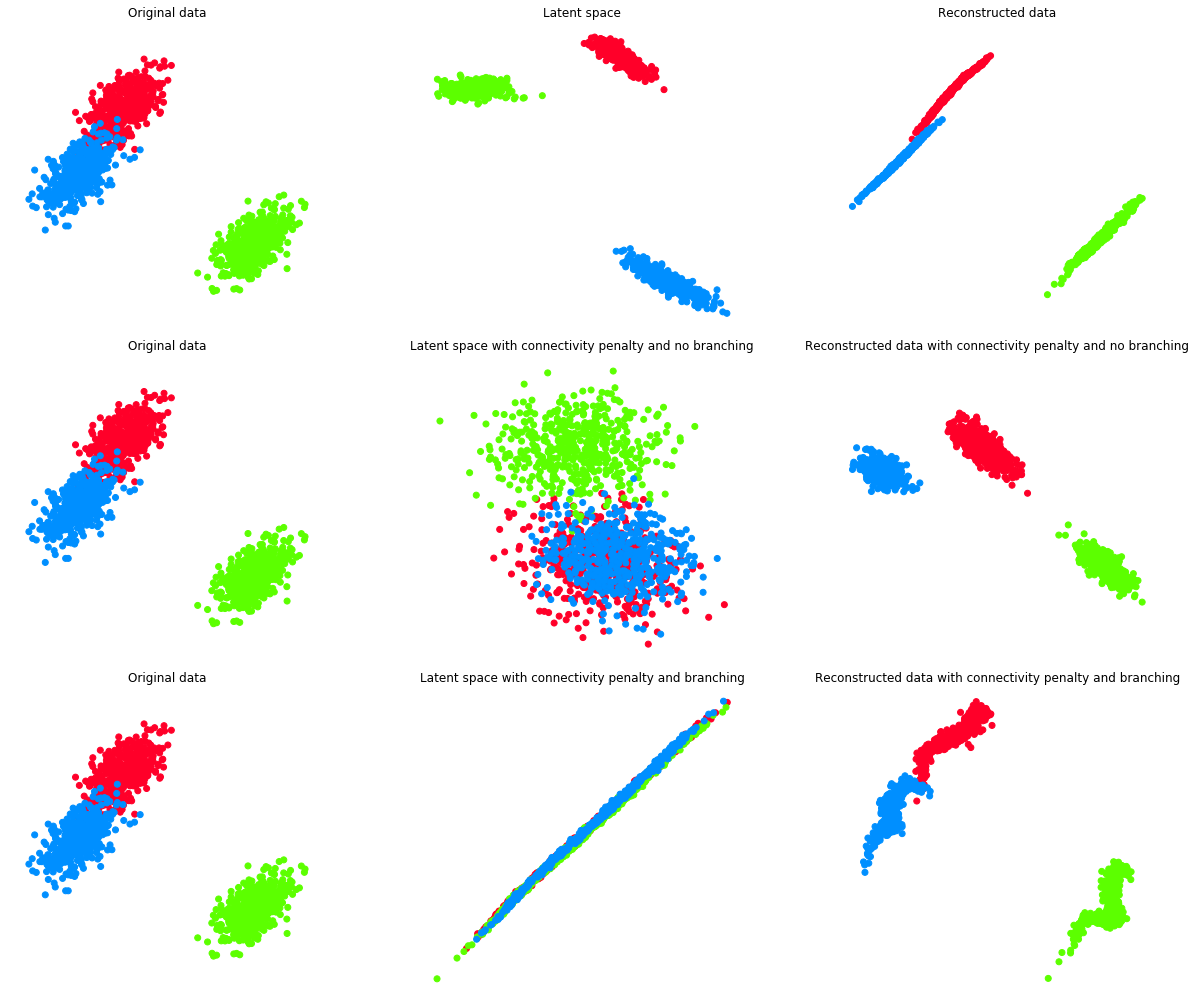

[6.517893, 7.5999494454636425, 62.46282]
[1.2206339, 1.6833772971043195, 2.2219274]
[1.2192174, 2.06211628064543, 16.281828]


In [5]:
fig, axes = plt.subplots(figsize=(17, 14), nrows=3, ncols=3)

data = data.to(model_no_penalty.device)
data_plot = data.cpu().data

ax = axes[0, 0]
ax.scatter(data_plot[:, 0], data_plot[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Original data')
ax.axis('off')

ax = axes[0, 1]
latent_space_no_penalty = model_no_penalty.autoencoder.encoder(data).cpu().data
ax.scatter(latent_space_no_penalty[:, 0], latent_space_no_penalty[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Latent space')
ax.axis('off')

ax = axes[0, 2]
reconstructed_data = model_no_penalty.autoencoder(data).cpu().data
ax.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Reconstructed data')
ax.axis('off')

ax = axes[1, 0]
ax.scatter(data_plot[:, 0], data_plot[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Original data')
ax.axis('off')

ax = axes[1, 1]
latent_space_no_branches = model_no_branches.autoencoder.encoder(data).cpu().data
ax.scatter(latent_space_no_branches[:, 0], latent_space_no_branches[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Latent space with connectivity penalty and no branching')
ax.axis('off')

ax = axes[1, 2]
reconstructed_data = model_no_branches.autoencoder(data).cpu().data
ax.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Reconstructed data with connectivity penalty and no branching')
ax.axis('off')

ax = axes[2, 0]
ax.scatter(data_plot[:, 0], data_plot[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Original data')
ax.axis('off')

ax = axes[2, 1]
latent_space_branches = model_branches.autoencoder.encoder(data).cpu().data
ax.scatter(latent_space_branches[:, 0], latent_space_branches[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Latent space with connectivity penalty and branching')
ax.axis('off')

ax = axes[2, 2]
reconstructed_data = model_branches.autoencoder(data).cpu().data
ax.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Reconstructed data with connectivity penalty and branching')
ax.axis('off')

plt.tight_layout()
plt.show()

fig.savefig('gaussian_high_dim_branches.eps')

print(barcode_stats(data))
print(barcode_stats(latent_space_no_branches))
print(barcode_stats(latent_space_branches))